In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy
from collections import defaultdict

In [36]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper Funcs
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def train_resnet(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    dataloaders, 
    device, 
    dataset_sizes,
    num_epochs=25
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    timing_data = defaultdict(list)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for minibatch_num, (inputs, labels) in enumerate(dataloaders[phase]):

                start = time.time()

                if minibatch_num % 1000 == 0:
                    print(f'Minibatch {minibatch_num}')

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                end = time.time()

                if phase == 'train':
                    timing_data[epoch].append(end - start)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, timing_data




In [26]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# Transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    'train': trainloader, 
    'val': testloader
}
dataset_sizes = {
    'train' : len(trainloader),
    'test' : len(testloader)
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


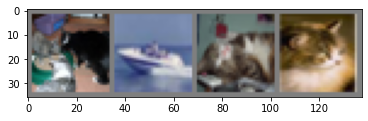

['cat', 'ship', 'cat', 'cat']


In [17]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print([classes[labels[i]] for i in  range(batch_size)])

In [29]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    dataloaders, 
    DEVICE, 
    dataset_sizes,
    num_epochs=1
)

Epoch 0/0
----------
Minibatch 0
Minibatch 10
Minibatch 20
Minibatch 30
Minibatch 40
Minibatch 50
Minibatch 60
Minibatch 70
Minibatch 80
Minibatch 90
Minibatch 100
Minibatch 110
Minibatch 120
Minibatch 130
Minibatch 140
Minibatch 150
Minibatch 160
Minibatch 170
Minibatch 180
Minibatch 190
Minibatch 200
Minibatch 210
Minibatch 220
Minibatch 230
Minibatch 240
Minibatch 250
Minibatch 260
Minibatch 270
Minibatch 280
Minibatch 290
Minibatch 300
Minibatch 310
Minibatch 320
Minibatch 330
Minibatch 340


KeyboardInterrupt: 

In [33]:
len(trainloader)

12500

# Cleaning Up Code

In [82]:
def get_cfar_dataset(trainset_size=None):

    # The output of torchvision datasets are PILImage images of range [0, 1]. 
    # Transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 4

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    if trainset_size is not None:
        trainset = [trainset[i] for i in range(trainset_size)]

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    dataloaders = {
        'train': trainloader, 
        'val': testloader
    }
    dataset_sizes = {
        'train' : len(trainloader),
        'val' : len(testloader)
    }

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return dataloaders, dataset_sizes, classes

def get_resnet_and_optimizer(classes):

    model_ft = models.resnet18(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(classes))

    model_ft = model_ft.to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    return  model_ft, criterion, optimizer_ft, exp_lr_scheduler

    

def collect_timing_data_resnet():

    # Get datasset
    print("Collecting CFAR dataset")
    dataloaders, dataset_sizes, classes = get_cfar_dataset(2000)

    print(len(dataloaders['train']))

    # Get model and training infrastructure
    print("Instantiating resnet")
    model, criterion, optimizer, scheduler = get_resnet_and_optimizer(classes)

    
    # Train and time
    print("Training ResNet")
    model, timing_data = train_resnet(
        model, 
        criterion, 
        optimizer, 
        scheduler,
        dataloaders, 
        DEVICE, 
        dataset_sizes,
        num_epochs=1
    )

    return model, timing_data 


In [83]:
model, timing_data = collect_timing_data_resnet()

Files already downloaded and verified
Files already downloaded and verified
500
Instantiating resnet
Training ResNet
Epoch 0/0
----------


/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Minibatch 0
train Loss: 10.3317 Acc: 0.6800
Minibatch 0
Minibatch 1000
Minibatch 2000
val Loss: 9.3340 Acc: 0.8848

Training complete in 0m 46s
Best val Acc: 0.884800


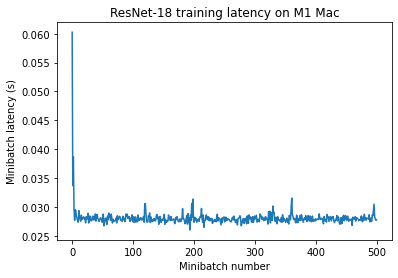

In [89]:
epoch_0 = timing_data[0]
plt.ylabel("Minibatch latency (s)")
plt.xlabel("Minibatch number")
plt.title("ResNet-18 training latency on M1 Mac")
plt.plot([i for i in range(len(epoch_0))], epoch_0)
plt.savefig("./training.png")

In [87]:
timing_data[0]

[0.06024909019470215,
 0.033677101135253906,
 0.038655996322631836,
 0.029799938201904297,
 0.027666091918945312,
 0.029517173767089844,
 0.02938699722290039,
 0.028348922729492188,
 0.028022050857543945,
 0.027597904205322266,
 0.02735424041748047,
 0.029356002807617188,
 0.028100967407226562,
 0.02786397933959961,
 0.02752995491027832,
 0.02859807014465332,
 0.027845144271850586,
 0.02815723419189453,
 0.02813577651977539,
 0.028287887573242188,
 0.027855873107910156,
 0.0280759334564209,
 0.027246713638305664,
 0.028304100036621094,
 0.02788686752319336,
 0.028092145919799805,
 0.028910160064697266,
 0.027211904525756836,
 0.027675867080688477,
 0.028437137603759766,
 0.027644872665405273,
 0.027785062789916992,
 0.027595996856689453,
 0.028304100036621094,
 0.02841496467590332,
 0.02777695655822754,
 0.02830219268798828,
 0.027755022048950195,
 0.02878284454345703,
 0.0275421142578125,
 0.028434038162231445,
 0.02871108055114746,
 0.027981042861938477,
 0.027864694595336914,
 0.027